# Introducción

La clasificación automática es una herramienta muy importante en la actualidad debido a la gran cantidad de información de la que disponemos, ya que nos permite utilizar algoritmos computacionales y técnicas de aprendizaje automático para categorizar datos en un conjunto de etiquetas definidas sin necesidad de intervención humana. La finalidad es asignar a los datos las categorías correctas de forma exacta y eficiente. Esto tiene bastantes aplicaciones en campos muy diversos, como detección de enfermedades a partir de imágenes de pacientes, clasificación de productos en un comercio electrónico, control de calidad, entre otros. Asimismo, esto es aplicable para textos, por ejemplo en sistemas de reconocimiento de spam, clasificación de documentos, etc.

El objetivo de este trabajo es realizar la categorización de tweets mediante algoritmos de clasificación, en particular Support Vector Machine (SVM) y Naive Bayes (NB) y comparar los resultados obtenidos usando distintas representaciones vectoriales. 

# Desarrollo

## Descripción del conjunto de datos

Para la realización de este trabajo se usó un conjunto de datos conformado por tweets acerca del tema de celulares, incluyendo algunas marcas en específico. Los elementos del conjunto de datos están formados por categoría, identificador, clase, texto y tipo.

El campo clase (klass) tiene los valores posibles information, positive, negative y neutral. Estas etiquetas fueron asignadas de forma manual por personas y se asumen como verdaderas. 

En este caso, nos concentramos en los campos texto y clase para realizar el entrenamiento de los algoritmos de clasificación.

A continuación se muestra un ejemplo de un tweet de este conjunto:

> {"categories": "[ \"DEVICE\", \"OS\" ]", "id": "d0fb202ea47c3cad448ea4e5e31bd404", "klass": "information", "text": "RT @matukpuntocom: Xperia Play se quedar\u00e1 sin Android 4.0 http://t.co/463lAcCp", "type": "Xperia"}

Se usarán 3 conjuntos: conjunto de datos, conjunto de validación y un conjunto de prueba.

## Implementación

La implementación de esta solución se utilizó Python. A continuación se muestra el código para los puntos más importantes.

### Preprocesamiento

In [ ]:
PUNCTUACTION = ";:,.\\-\"'/"
SYMBOLS = "()[]¿?¡!{}~<>|"
SKIP_SYMBOLS = set(PUNCTUACTION + SYMBOLS)
SKIP_SYMBOLS_AND_SPACES = set(PUNCTUACTION + SYMBOLS + '\t\n\r ')

def normalize_text(input_str,
                   punct=False,
                   accents=False,
                   max_dup=2):
    nfkd_f = unicodedata.normalize('NFKD', input_str)
    n_str = []
    c_prev = ''
    cc_prev = 0
    for c in nfkd_f:
        if not punct:
            if c in SKIP_SYMBOLS:
                continue
        if not accents and unicodedata.combining(c):
            continue
        if c_prev == c:
            cc_prev += 1
            if cc_prev >= max_dup:
                continue
        else:
            cc_prev = 0
        n_str.append(c)
        c_prev = c
    return "".join(n_str)

La función anterior se utiliza para preprocesar el texto. Permite remover acentos, signos de puntuación, y limitar la cantidad de caracteres duplicados consecutivos. Recibe como parámetro el texto que se desee preprocesar. También tiene parámetros que permiten conservar la puntuación, acentos (falsos por defecto )y el numero de caracteres duplicados (2, por defecto). 

### Lectura de datos

In [ ]:
def line_iterator(filename):
    if filename.endswith(".gz"):
        f = gzip.GzipFile(filename)
    else:
        f = open(filename, encoding='utf8')

    while True:
        line = f.readline()
        # Test the type of the line and encode it if neccesary...
        if type(line) is bytes:
            line = str(line, encoding='utf8')

        # If the line is empty, we are done...
        if len(line) == 0:
            break

        line = line.strip()
        # If line is empty, jump to next...
        if len(line) == 0:
            continue

        yield line

    # Close the file...
    f.close()

def tweet_iterator(filename):
    for line in line_iterator(filename):
        yield json.loads(line)

Las funciones anteriores nos ayudan a leer y procesar los tweets del conjunto de datos, a partir de un archivo de texto usando un enfoque basado en iteradores. Finalmente, devuelven un objeto JSON que nos permite realizar operaciones con él. Recibe como parámetro el nombre del archivo a utilizar.

### Carga del conjunto de datos

Esta función nos permite obtener el texto preprocesado, las clases y las categorías y tipos asociados a cada tweet en el conjunto de datos. Recibe como parámetro el nombre del archivo del conjunto de datos.

In [8]:
def load_corpus(file):
    X=[]
    Y=[]
    C=[]
    for review in tweet_iterator(file):
        text = normalize_text(review['text'])
        X.append(text.lower())
        Y.append(review['klass'])
        C.append(review['categories'] + "#" + review['type'] )
    return X,Y,C

### Obteniendo las categorías y tipos

Una vez obtenidos los tipos y categorías de cada tweet en el conjunto de prueba, podemos separarlos mediante el siguiente código:

In [ ]:
C_types = [string.split("#")[1] for string in C_unk]
C_cats = [string.split("#")[0] for string in C_unk]

### Vectorización de los datos

Para poder entrenar los algoritmos de clasificación, se debe transformar el texto a una representación numérica. En este caso, se eligieron 2 transformaciones: frecuencia de términos (TF) y  frecuencia de término – frecuencia inversa de documento (TF-IDF). A continuación se muestra el código:

Primero se cargan los conjuntos de datos: el conjunto formado por el archivo cellphones_train.json servirá como conjunto de entrenamiento, cellphones_train.json como conjunto de validación y cellphones_unk.json será el conjunto de prueba. En todos los casos, se excluyen las stop-words.

In [ ]:
X, Y, C = load_corpus("cellphones_train.json")
X_test, Y_test, C_test = load_corpus("cellphones_test.json")
X_unk,Y_unk, C_unk = load_corpus("cellphones_unk.json")

Posteriormente, usamos CountVectorizer para obtener la representación vectorial usando la frecuencia de términos, para los textos de los tweets del conjunto de entrenamiento:

In [ ]:
vectorizer = CountVectorizer(stop_words=stopwords.words('spanish'))  
X_vec_tf = vectorizer.fit_transform(X)

De forma análoga, obtenemos la representación usando TF-IDF:

In [ ]:
tfidfvec = TfidfVectorizer(stop_words=stopwords.words('spanish'))  
X_vec_tf_idf = tfidfvec.fit_transform(X)

### Entrenamiento de los algoritmos de clasificación

Para la clasificación se eligieron 2 algoritmos: Naive Bayes (NB) y Support Vector Machine (SVM). Para cada algoritmo se usarán las 2 representaciones TF y TF-IDF.

Entrenando Naive Bayes con TF:

In [ ]:
mnb_tf = MultinomialNB()
mnb_tf.fit(X_vec_tf, Y)

Entrenando Naive Bayes con TF-IDF:

In [ ]:
mnb_tfidf = MultinomialNB()
mnb_tfidf.fit(X_vec_tf_idf, Y)

Entrenando SVM con TF:

In [ ]:
svc_tf = LinearSVC(random_state=0, max_iter=3000)
svc_tf.fit(X_vec_tf, Y)

Entrenando SVM con TF-IDF:

In [ ]:
svc_tfidf = LinearSVC(random_state=0, max_iter=3000)
svc_tfidf.fit(X_vec_tf_idf, Y)

### Predicciones

Si se desea realizar predicciones debemos vectorizar los datos de prueba usando TF y TF-IDF y posteriormente usar el modelo correspondiente. A continuación se muestra el código para realizar lo descrito:

Primero se vectorizan los datos sobre los que querramos predecir. En este caso, los conjuntos de validación y prueba:

In [ ]:
X_test_vec_tf_idf = tfidfvec.transform(X_test)
X_test_vec_tf = vectorizer.transform(X_test)

X_unk_vec_tf_idf = tfidfvec.transform(X_unk)
X_unk_vec_tf = vectorizer.transform(X_unk)

Prediciendo datos con NB y TF para los conjuntos de validación y prueba:

In [ ]:
y_mnb_test_predict_tf = mnb_tf.predict(X_test_vec_tf)
y_mnb_predict_tf = mnb_tf.predict(X_unk_vec_tf)

Prediciendo datos con NB y TF-IDF para los conjuntos de validación y prueba:

In [ ]:
y_mnb_test_predict_tfidf = mnb_tfidf.predict(X_test_vec_tf_idf)
y_mnb_predict_tfidf = mnb_tfidf.predict(X_unk_vec_tf_idf)

Prediciendo datos con SVM para TF para los conjuntos de validación y prueba:

In [ ]:
y_svm_test_predict_tf = svc_tf.predict(X_test_vec_tf)
y_svm_predict_tf = svc_tf.predict(X_unk_vec_tf)

Prediciendo datos con SVM para TF-IDF para los conjuntos de validación y prueba:

In [ ]:
y_svm_test_predict_tfidf = svc_tfidf.predict(X_test_vec_tf_idf)
y_svm_predict_tfidf = svc_tfidf.predict(X_unk_vec_tf_idf)

### Asociando las predicciones con las categorías y tipos

Ya que se han realizado las predicciones, podemos asociarlas con los tipos y categorías de los tweets usando el siguiente código. En este caso, se hará sólo para el conjunto de prueba:

Asociamos las tipos:

In [ ]:
pred_types_mnb_tf = list(zip( C_types, y_mnb_predict_tf))
pred_types_mnb_tfidf = list(zip( C_types, y_mnb_predict_tfidf))
pred_types_svm_tf = list(zip(C_types, y_svm_predict_tf))
pred_types_svm_tfidf = list(zip( C_types, y_svm_predict_tfidf))

Asociamos las categorías:

pred_cats_mnb_tf = list(zip(C_cats, y_mnb_predict_tf))
pred_cats_mnb_tfidf = list(zip( C_cats, y_mnb_predict_tfidf))
pred_cats_svm_tf = list(zip(  C_cats, y_svm_predict_tf))
pred_cats_svm_tfidf = list(zip( C_cats, y_svm_predict_tfidf))

Esto nos servirá como entrada para una de las funciones que nos permiten graficar los resultados.

### Evaluación de desempeño

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
def print_scores(true_labels, predicted_labels):
    print("Accuracy  =", accuracy_score(true_labels, predicted_labels))
    print("F1 =", f1_score(true_labels, predicted_labels, average='macro'))
    print("Micro F1  =", f1_score(true_labels, predicted_labels, average='micro'))

La función anterior nos permite medir el desempeño del modelo entrenado usando como métricas la exactitud y $F_{1}$ micro y macro. Recibe como parámetros las clases reales y las predecidas.

### Visualización de resultados

#### Comparación de predicciones

In [21]:
def create_barplots(data1, data2, label1 , label2, title, log = False):
    # Count the elements in both data1 and data2
    unique_elements1, counts1 = np.unique(data1, return_counts=True)
    unique_elements2, counts2 = np.unique(data2, return_counts=True)

    # Create a figure with a single subplot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Set the width of the bars for positioning
    width = 0.4

    # Calculate the positions for the bars
    x_pos1 = np.arange(len(unique_elements1))
    x_pos2 = np.arange(len(unique_elements2))

    # Plot the bars for data1
    ax.bar(x_pos1 - width/2, counts1, width=width, alpha=0.5, color="red", label=label1)

    # Plot the bars for data2
    ax.bar(x_pos2 + width/2, counts2, width=width, alpha=0.5, label=label2)

    ax.set_xlabel('')
    ax.set_ylabel('Conteo')
    ax.set_title(title)
    if log:
        ax.set_yscale('log')
    ax.set_xticks(x_pos1)  # Set x-ticks to the positions of data1
    ax.set_xticklabels(unique_elements1)  # Set x-tick labels to the unique elements of data1
    ax.legend()  # Add a legend

    # Show the plot
    plt.show()

Esta función nos permite comparar las predicciones obtenidas para cada algoritmo de aprendizaje automático mediante una gráfica de barras. Recibe 2 arreglos de datos, las etiquetas respectivas para cada uno y el título del gráfico. Tiene un parámetro, por defecto falso, que permite usar escala logarítmica en el eje y.

#### Conteo de predicciones sobre categoría y tipo

In [ ]:
def stacked_barplot(data, title, xlabel, ylabel):
    # Extract unique x-axis labels and subgroups
    x_labels = list(set(item[0] for item in data))
    subgroups = list(set(item[1] for item in data))

    # Create a dictionary to store subgroup data
    subgroup_data = {subgroup: [0] * len(x_labels) for subgroup in subgroups}

    # Assign colors for subgroups
    #colors = plt.cm.get_cmap('tab20', len(subgroups))  # Use a colormap for distinct colors

    # Fill in the data for each subgroup
    for item in data:
        x_value, subgroup = item
        subgroup_data[subgroup][x_labels.index(x_value)] += 1

    # Create a horizontal stacked bar plot
    fig, ax = plt.subplots()
    width = 0.5

    bottom_values = np.zeros(len(x_labels))

    for i, subgroup in enumerate(subgroups):
        data_values = [subgroup_data[subgroup][i] for i in range(len(x_labels))]
        ax.barh(x_labels, data_values, width, label=subgroup, left=bottom_values)
        bottom_values += data_values

    ax.set_ylabel(xlabel)
    ax.set_xlabel(ylabel)
    ax.set_title(title)
    ax.legend(title="Clases")

    plt.show()


La función anterior nos permite obtener una gráfica de barras apilada donde se muestra el conteo de las predicciones por clase, para cada tipo o categoría, según sea el caso. Recibe como parámetros una lista de tuplas donde el primer elemento es el tipo o clase, el título para el gráfico y las etiquetas para los ejes x y y.

## Resultados

### Desempeño de los algoritmos

Evaluamos las predicciones obtenidas por los algoritmos para el conjunto de validación usando la función print_scores, obtenemos la siguiente información:

| Algoritmo      | Exactitud | $F_{1}$ macro      | $F_{1}$ micro |
| ----------- | ----------- | ----------- | ----------- |
| Naive Bayes TF      | 0.7343       | 0.4875      | 0.7343       |
| Naive Bayes TF-IDF   | 0.7086        | 0.3702      | 0.7086       |
| SVM TF      | 0.7296       | 0.5766      | 0.7296       |
| SVM TF-IDF   | 0.7476        | 0.5862      | 0.7476       |

Con base en la tabla anterior, podemos observar que los algoritmos tienen una exactitud y $F_{1}$ micro similares pero Naive Bayes FT y SVM TF-IDF tienen los mejores valores. Sin embargo, en cuestión de $F_{1}$ macro, Naive Bayes TF posee el valor más bajo, mientras que los algoritmos SVM tienen los más altos. Esto nos indica que estos algoritmos se comportan mejor para la clasificación  para todas las clases, es decir generalizan mejor y tendrán predicciones más balanceadas.

### Predicciones por vectorización y algoritmo

Una vez entrenado el algoritmo, realizamos las predicciones para Naive Bayes y SVM con diferentes representaciones vectorialez y obtenemos las siguientes gráficas, usando la función create_barplots()

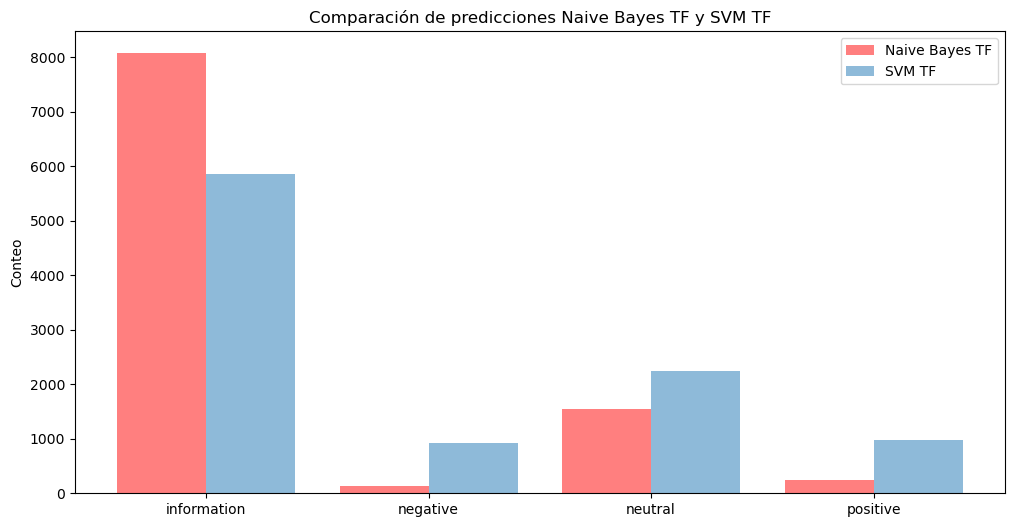

En la figura anterior podemos observar que la mayor parte de las predicciones hechas usando TF  fueron de tipo information, seguido de neutral, positive y finalmente negative. Sin embargo, cada algoritmo predijo una cantidad diferente para cada una de estas. En este caso Naive Bayes le asignó la clase information a una cantidad mayor de tweets en comparación a SVM y a negative le asignó muchas menos.

En el caso de las predicciones hechas usando TF-IDF para cada algoritmo, obtenemos lo siguiente:

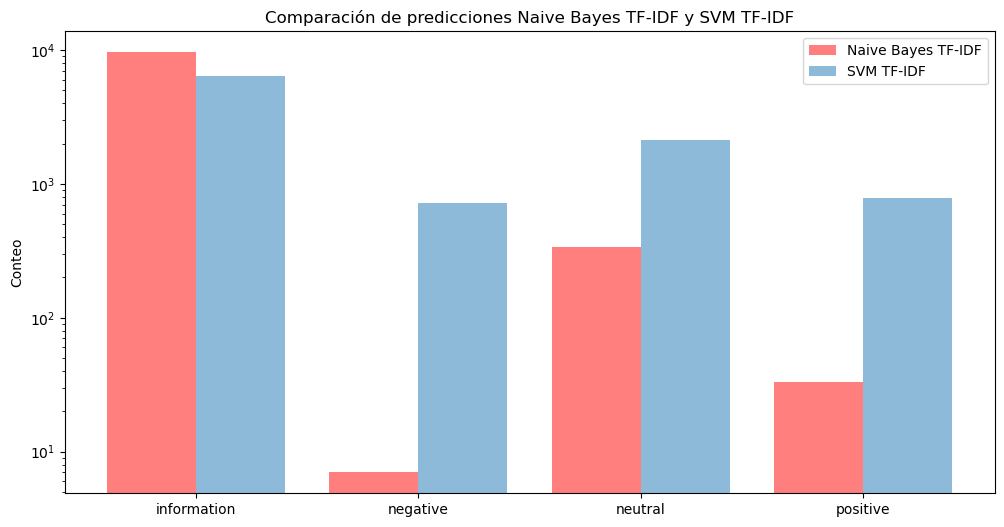

En la figura anterior podemos notar que Naive Bayes obtiene una cantidad muy inferior de clases negative y positive con respecto a SVM. Al igual que en la gráfica anterior, se observa que la mayoría de las predicciones son del tipo information.

### Predicciones por tipo

Si analizamos los tweets, obtenemos que hay 12 tipos únicos: Symbian, Iphone, Lucid, Windows Phone, Lumia, N9, Optimus, Xperia, Celular, Android, Meego y Galaxy. Con base en esta información, podemos agrupar las predicciones por tipo.

A continuación se muestran los resultados:

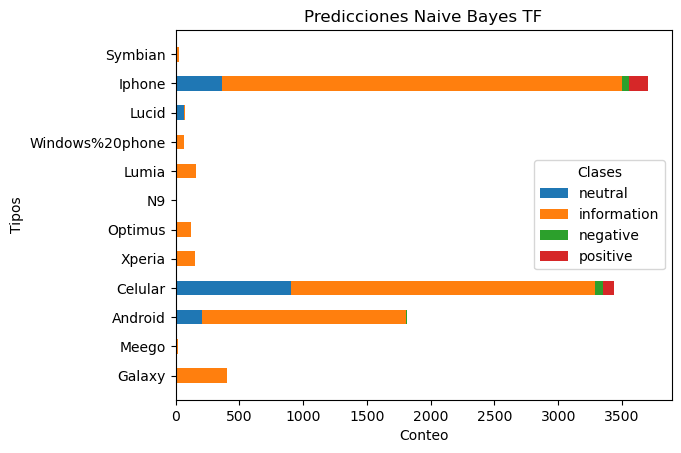

En la figura anterior podemos ver las predicciones realizadas usando Naive Bayes con TF. Se observa que los tipos con mayores predicciones son Iphone, celular y android. Para Iphone la mayor parte de los comentarios son de clase information, seguido de neutral, positive y negative. Para Celular, se tiene un comportamiento similar pero los comentarios neutrales obtienen mayor proporción mientras que en el caso de Android, la mayor parte son de la clase information, neutral, negative y positive en ese orden. En general, la mayor parte de las predicciones son de clase information.

En la siguiente tabla se tienen las predicciones obtenidas por tipo:

In [44]:
display(HTML('<table border="1" class="dataframe">\n   <caption>Clases predecidas por tipo usando Naive Bayes TF </caption> <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>information</th>\n      <th>negative</th>\n      <th>neutral</th>\n      <th>positive</th>\n    </tr>\n    <tr>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>Android</th>\n      <td>1598.0</td>\n      <td>12.0</td>\n      <td>205.0</td>\n      <td>2.0</td>\n    </tr>\n    <tr>\n      <th>Celular</th>\n      <td>2380.0</td>\n      <td>64.0</td>\n      <td>909.0</td>\n      <td>85.0</td>\n    </tr>\n    <tr>\n      <th>Galaxy</th>\n      <td>404.0</td>\n      <td>0.0</td>\n      <td>1.0</td>\n      <td>1.0</td>\n    </tr>\n    <tr>\n      <th>Iphone</th>\n      <td>3132.0</td>\n      <td>57.0</td>\n      <td>365.0</td>\n      <td>149.0</td>\n    </tr>\n    <tr>\n      <th>Lucid</th>\n      <td>2.0</td>\n      <td>0.0</td>\n      <td>70.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th>Lumia</th>\n      <td>160.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th>Meego</th>\n      <td>20.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th>N9</th>\n      <td>13.0</td>\n      <td>0.0</td>\n      <td>2.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th>Optimus</th>\n      <td>116.0</td>\n      <td>0.0</td>\n      <td>3.0</td>\n      <td>1.0</td>\n    </tr>\n    <tr>\n      <th>Symbian</th>\n      <td>26.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th>Windows%20phone</th>\n      <td>68.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th>Xperia</th>\n      <td>155.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n    </tr>\n  </tbody>\n</table>'))

,information,negative,neutral,positive
,,,,
Android,1598.0,12.0,205.0,2.0
Celular,2380.0,64.0,909.0,85.0
Galaxy,404.0,0.0,1.0,1.0
Iphone,3132.0,57.0,365.0,149.0
Lucid,2.0,0.0,70.0,0.0
Lumia,160.0,0.0,0.0,0.0
Meego,20.0,0.0,0.0,0.0
N9,13.0,0.0,2.0,0.0
Optimus,116.0,0.0,3.0,1.0


En la siguiente figura se tienen las predicciones obtenidas mediante Naive Bayes usando TF-IDF. Con base en la tabla y la gráfica, podemos notar que existen pocas predicciones para las clases negative, positive (17 y 33 respectivamente) y neutral mientras que information forma la mayor proporción de las predicciones.

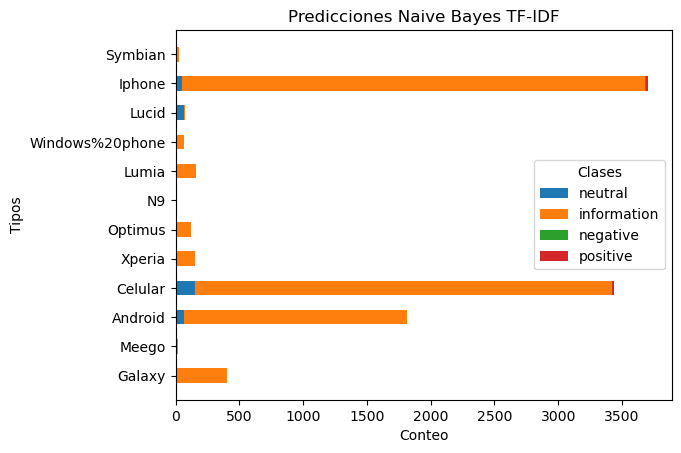

In [47]:
display(HTML('<table border="1" class="dataframe">\n  <caption>Clases predecidas por tipo usando Naive Bayes TF-IDF </caption> <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>information</th>\n      <th>negative</th>\n      <th>neutral</th>\n      <th>positive</th>\n    </tr>\n    <tr>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>Android</th>\n      <td>1750.0</td>\n      <td>0.0</td>\n      <td>67.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th>Celular</th>\n      <td>3268.0</td>\n      <td>0.0</td>\n      <td>151.0</td>\n      <td>19.0</td>\n    </tr>\n    <tr>\n      <th>Galaxy</th>\n      <td>406.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th>Iphone</th>\n      <td>3632.0</td>\n      <td>7.0</td>\n      <td>50.0</td>\n      <td>14.0</td>\n    </tr>\n    <tr>\n      <th>Lucid</th>\n      <td>3.0</td>\n      <td>0.0</td>\n      <td>69.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th>Lumia</th>\n      <td>160.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th>Meego</th>\n      <td>20.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th>N9</th>\n      <td>15.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th>Optimus</th>\n      <td>120.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th>Symbian</th>\n      <td>26.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th>Windows%20phone</th>\n      <td>68.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th>Xperia</th>\n      <td>155.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n    </tr>\n  </tbody>\n</table>'))

,information,negative,neutral,positive
,,,,
Android,1750.0,0.0,67.0,0.0
Celular,3268.0,0.0,151.0,19.0
Galaxy,406.0,0.0,0.0,0.0
Iphone,3632.0,7.0,50.0,14.0
Lucid,3.0,0.0,69.0,0.0
Lumia,160.0,0.0,0.0,0.0
Meego,20.0,0.0,0.0,0.0
N9,15.0,0.0,0.0,0.0
Optimus,120.0,0.0,0.0,0.0


Para el caso de las predicciones hechas con SVM usando TF podemos ver que hay una proporción mayor de clases positive y negative en los tipos Iphone, Celular y Android, especialmente si lo comparamos con los resultados de Naive Bayes usando TF. Es interesante notar que en el tipo Galaxy, se obtienen predicciones para todas las clases, mientras que con Naive Bayes con TF, casi todas las predicciones correspondían a information.

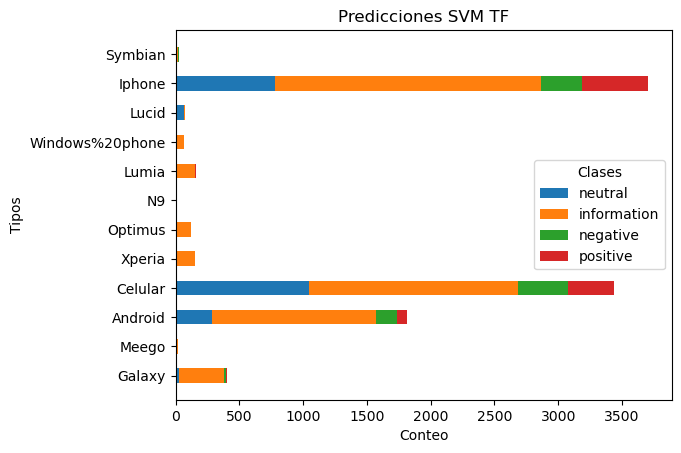

In [49]:
display(HTML('<table border="1" class="dataframe">\n <caption>Clases predecidas por tipo usando SVM TF </caption> <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>information</th>\n      <th>negative</th>\n      <th>neutral</th>\n      <th>positive</th>\n    </tr>\n    <tr>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>Android</th>\n      <td>1284.0</td>\n      <td>168.0</td>\n      <td>286.0</td>\n      <td>79.0</td>\n    </tr>\n    <tr>\n      <th>Celular</th>\n      <td>1634.0</td>\n      <td>395.0</td>\n      <td>1047.0</td>\n      <td>362.0</td>\n    </tr>\n    <tr>\n      <th>Galaxy</th>\n      <td>354.0</td>\n      <td>14.0</td>\n      <td>26.0</td>\n      <td>12.0</td>\n    </tr>\n    <tr>\n      <th>Iphone</th>\n      <td>2081.0</td>\n      <td>323.0</td>\n      <td>781.0</td>\n      <td>518.0</td>\n    </tr>\n    <tr>\n      <th>Lucid</th>\n      <td>3.0</td>\n      <td>0.0</td>\n      <td>69.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th>Lumia</th>\n      <td>146.0</td>\n      <td>4.0</td>\n      <td>5.0</td>\n      <td>5.0</td>\n    </tr>\n    <tr>\n      <th>Meego</th>\n      <td>19.0</td>\n      <td>0.0</td>\n      <td>1.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th>N9</th>\n      <td>10.0</td>\n      <td>0.0</td>\n      <td>5.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th>Optimus</th>\n      <td>113.0</td>\n      <td>0.0</td>\n      <td>6.0</td>\n      <td>1.0</td>\n    </tr>\n    <tr>\n      <th>Symbian</th>\n      <td>19.0</td>\n      <td>5.0</td>\n      <td>2.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th>Windows%20phone</th>\n      <td>60.0</td>\n      <td>3.0</td>\n      <td>5.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th>Xperia</th>\n      <td>141.0</td>\n      <td>2.0</td>\n      <td>9.0</td>\n      <td>3.0</td>\n    </tr>\n  </tbody>\n</table>'))

,information,negative,neutral,positive
,,,,
Android,1284.0,168.0,286.0,79.0
Celular,1634.0,395.0,1047.0,362.0
Galaxy,354.0,14.0,26.0,12.0
Iphone,2081.0,323.0,781.0,518.0
Lucid,3.0,0.0,69.0,0.0
Lumia,146.0,4.0,5.0,5.0
Meego,19.0,0.0,1.0,0.0
N9,10.0,0.0,5.0,0.0
Optimus,113.0,0.0,6.0,1.0


Para las predicciones realizadas con SVM usando TF-IDF, podemos notar un comportamiento similar a SVM con TF. Sin embargo, podemos observar un cambio en las predicciones para el tipo Galaxy que tiene 375 information, 8 negative, 14 neutral, 9 positive y tenía 354, 14,26,12; en este caso, se predijeron más comentarios como de clase information y se redujo  el número predicciones para las demás clases.

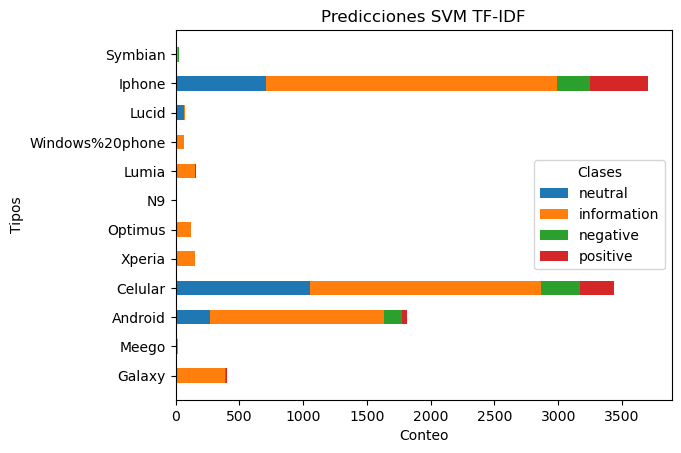

In [50]:
display(HTML('<table border="1" class="dataframe">\n <caption>Clases predecidas por tipo usando SVM TF-IDF </caption> <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>information</th>\n      <th>negative</th>\n      <th>neutral</th>\n      <th>positive</th>\n    </tr>\n    <tr>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>Android</th>\n      <td>1366.0</td>\n      <td>139.0</td>\n      <td>267.0</td>\n      <td>45.0</td>\n    </tr>\n    <tr>\n      <th>Celular</th>\n      <td>1807.0</td>\n      <td>306.0</td>\n      <td>1056.0</td>\n      <td>269.0</td>\n    </tr>\n    <tr>\n      <th>Galaxy</th>\n      <td>375.0</td>\n      <td>8.0</td>\n      <td>14.0</td>\n      <td>9.0</td>\n    </tr>\n    <tr>\n      <th>Iphone</th>\n      <td>2282.0</td>\n      <td>259.0</td>\n      <td>708.0</td>\n      <td>454.0</td>\n    </tr>\n    <tr>\n      <th>Lucid</th>\n      <td>3.0</td>\n      <td>0.0</td>\n      <td>69.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th>Lumia</th>\n      <td>151.0</td>\n      <td>1.0</td>\n      <td>4.0</td>\n      <td>4.0</td>\n    </tr>\n    <tr>\n      <th>Meego</th>\n      <td>20.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th>N9</th>\n      <td>13.0</td>\n      <td>0.0</td>\n      <td>2.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th>Optimus</th>\n      <td>116.0</td>\n      <td>0.0</td>\n      <td>4.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th>Symbian</th>\n      <td>23.0</td>\n      <td>3.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th>Windows%20phone</th>\n      <td>60.0</td>\n      <td>3.0</td>\n      <td>5.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th>Xperia</th>\n      <td>144.0</td>\n      <td>2.0</td>\n      <td>5.0</td>\n      <td>4.0</td>\n    </tr>\n  </tbody>\n</table>'))

,information,negative,neutral,positive
,,,,
Android,1366.0,139.0,267.0,45.0
Celular,1807.0,306.0,1056.0,269.0
Galaxy,375.0,8.0,14.0,9.0
Iphone,2282.0,259.0,708.0,454.0
Lucid,3.0,0.0,69.0,0.0
Lumia,151.0,1.0,4.0,4.0
Meego,20.0,0.0,0.0,0.0
N9,13.0,0.0,2.0,0.0
Optimus,116.0,0.0,4.0,0.0


### Predicciones por categoría

De forma análoga a los tipos, se obtiene que hay 7 categorías únicas: OS#Mobile, Device#OS, OS, Device, Mobile, Device#OS#Mobile y Device#Mobile . Con base en esta información, podemos agrupar las predicciones por categoría.

A continuación se muestran los resultados:

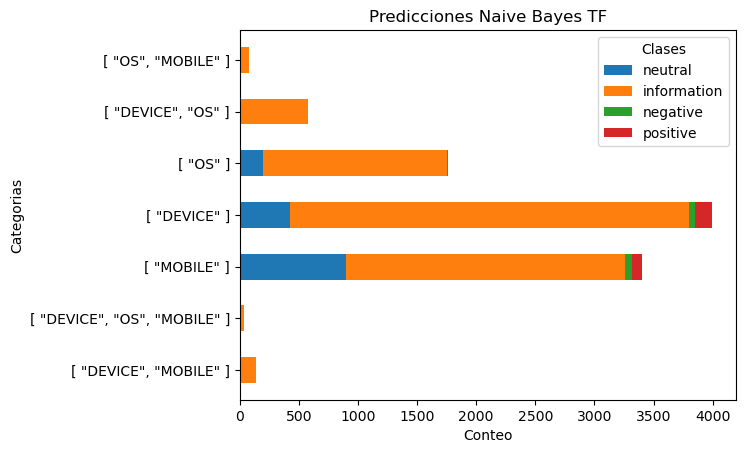

In [64]:
display(HTML('<table border="1" class="dataframe">\n <caption>Clases predecidas por categoría usando Naive Bayes TF </caption> <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>information</th>\n      <th>negative</th>\n      <th>neutral</th>\n      <th>positive</th>\n    </tr>\n    <tr>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th> "DEVICE" </th>\n      <td>3367.0</td>\n      <td>50.0</td>\n      <td>429.0</td>\n      <td>148.0</td>\n    </tr>\n    <tr>\n      <th> "DEVICE", "MOBILE" </th>\n      <td>121.0</td>\n      <td>6.0</td>\n      <td>13.0</td>\n      <td>2.0</td>\n    </tr>\n    <tr>\n      <th> "DEVICE", "OS" </th>\n      <td>567.0</td>\n      <td>1.0</td>\n      <td>10.0</td>\n      <td>1.0</td>\n    </tr>\n    <tr>\n      <th> "DEVICE", "OS", "MOBILE" </th>\n      <td>34.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th> "MOBILE" </th>\n      <td>2359.0</td>\n      <td>64.0</td>\n      <td>896.0</td>\n      <td>85.0</td>\n    </tr>\n    <tr>\n      <th> "OS" </th>\n      <td>1553.0</td>\n      <td>12.0</td>\n      <td>198.0</td>\n      <td>2.0</td>\n    </tr>\n    <tr>\n      <th> "OS", "MOBILE" </th>\n      <td>73.0</td>\n      <td>0.0</td>\n      <td>9.0</td>\n      <td>0.0</td>\n    </tr>\n  </tbody>\n</table>'))

,information,negative,neutral,positive
,,,,
"""DEVICE""",3367.0,50.0,429.0,148.0
"""DEVICE"", ""MOBILE""",121.0,6.0,13.0,2.0
"""DEVICE"", ""OS""",567.0,1.0,10.0,1.0
"""DEVICE"", ""OS"", ""MOBILE""",34.0,0.0,0.0,0.0
"""MOBILE""",2359.0,64.0,896.0,85.0
"""OS""",1553.0,12.0,198.0,2.0
"""OS"", ""MOBILE""",73.0,0.0,9.0,0.0


En la tabla y la gráfica anterior podemos ver las predicciones realizadas por Naive Bayes usando TF. Podemos notar que sólo la categoría DEVICE#OS#MOBILE solo tiene predicciones de clase information mientras que OS#Mobile solo posee predicciones de clase information y neutral. Por otra parte, OS, Device y Mobile son las categorías que tienen predicciones de todas las clases.

En la siguiente gráfica  podemos observar las predicciones realizadas por Naive Bayes usando TF-IDF. En este caso podemos notar que las predicciones de clase negative sólo son 7 en total, mientras que para positive son 33 en total para todas las categorías. A diferencia de Naive Bayes con TF, hubo categorías que disminuyeron en cuanto a predicciones de clase positive, como OS. En general, la clase information domina las predicciones.

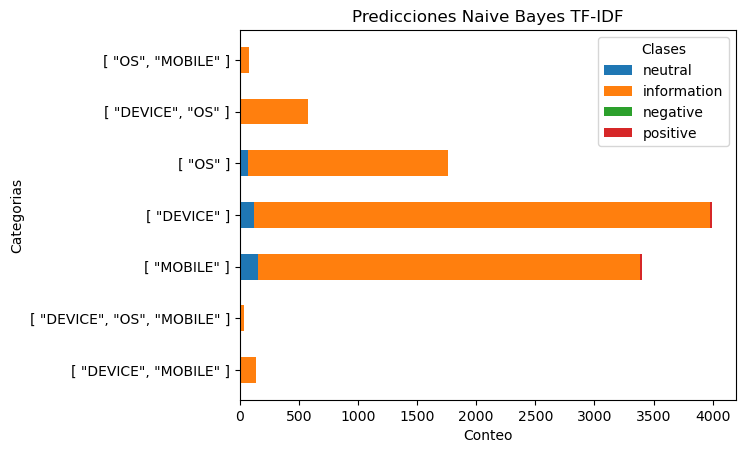

In [61]:
display(HTML('<table border="1" class="dataframe">\n <caption>Clases predecidas por categoría usando Naive Bayes TF-IDF </caption> <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>information</th>\n      <th>negative</th>\n      <th>neutral</th>\n      <th>positive</th>\n    </tr>\n    <tr>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th> "DEVICE" </th>\n      <td>3860.0</td>\n      <td>1.0</td>\n      <td>119.0</td>\n      <td>14.0</td>\n    </tr>\n    <tr>\n      <th> "DEVICE", "MOBILE" </th>\n      <td>136.0</td>\n      <td>6.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th> "DEVICE", "OS" </th>\n      <td>579.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th> "DEVICE", "OS", "MOBILE" </th>\n      <td>34.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th> "MOBILE" </th>\n      <td>3234.0</td>\n      <td>0.0</td>\n      <td>151.0</td>\n      <td>19.0</td>\n    </tr>\n    <tr>\n      <th> "OS" </th>\n      <td>1698.0</td>\n      <td>0.0</td>\n      <td>67.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th> "OS", "MOBILE" </th>\n      <td>82.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n    </tr>\n  </tbody>\n</table>'))

,information,negative,neutral,positive
,,,,
"""DEVICE""",3860.0,1.0,119.0,14.0
"""DEVICE"", ""MOBILE""",136.0,6.0,0.0,0.0
"""DEVICE"", ""OS""",579.0,0.0,0.0,0.0
"""DEVICE"", ""OS"", ""MOBILE""",34.0,0.0,0.0,0.0
"""MOBILE""",3234.0,0.0,151.0,19.0
"""OS""",1698.0,0.0,67.0,0.0
"""OS"", ""MOBILE""",82.0,0.0,0.0,0.0


En la siguiente gráfica se tienen los resultados de las predicciones mediante obtenidas mediant SVM usando TF. Se puede notar que existe mayor proporción de clases positivas, negativas y neutras comparadas con Naive Bayes con TF o TF-IDF. 

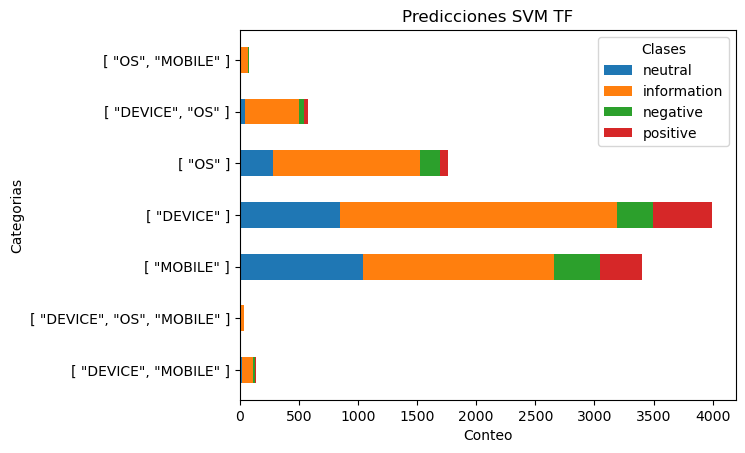

In [62]:
display(HTML('<table border="1" class="dataframe">\n <caption>Clases predecidas por categoría usando SVM TF </caption> <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>information</th>\n      <th>negative</th>\n      <th>neutral</th>\n      <th>positive</th>\n    </tr>\n    <tr>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th> "DEVICE" </th>\n      <td>2348.0</td>\n      <td>301.0</td>\n      <td>846.0</td>\n      <td>499.0</td>\n    </tr>\n    <tr>\n      <th> "DEVICE", "MOBILE" </th>\n      <td>95.0</td>\n      <td>13.0</td>\n      <td>19.0</td>\n      <td>15.0</td>\n    </tr>\n    <tr>\n      <th> "DEVICE", "OS" </th>\n      <td>459.0</td>\n      <td>38.0</td>\n      <td>47.0</td>\n      <td>35.0</td>\n    </tr>\n    <tr>\n      <th> "DEVICE", "OS", "MOBILE" </th>\n      <td>33.0</td>\n      <td>0.0</td>\n      <td>1.0</td>\n      <td>0.0</td>\n    </tr>\n    <tr>\n      <th> "MOBILE" </th>\n      <td>1621.0</td>\n      <td>383.0</td>\n      <td>1040.0</td>\n      <td>360.0</td>\n    </tr>\n    <tr>\n      <th> "OS" </th>\n      <td>1242.0</td>\n      <td>170.0</td>\n      <td>284.0</td>\n      <td>69.0</td>\n    </tr>\n    <tr>\n      <th> "OS", "MOBILE" </th>\n      <td>66.0</td>\n      <td>9.0</td>\n      <td>5.0</td>\n      <td>2.0</td>\n    </tr>\n  </tbody>\n</table>'))

,information,negative,neutral,positive
,,,,
"""DEVICE""",2348.0,301.0,846.0,499.0
"""DEVICE"", ""MOBILE""",95.0,13.0,19.0,15.0
"""DEVICE"", ""OS""",459.0,38.0,47.0,35.0
"""DEVICE"", ""OS"", ""MOBILE""",33.0,0.0,1.0,0.0
"""MOBILE""",1621.0,383.0,1040.0,360.0
"""OS""",1242.0,170.0,284.0,69.0
"""OS"", ""MOBILE""",66.0,9.0,5.0,2.0


La última gráfica se tienen los resultados de las predicciones mediante obtenidas mediante SVM usando TF-IDF. Se puede notar que las predicciones siguen una distribución similar a SMV con TF, pero hay categorías donde las predicciones de clase information aumentaron, como Device, Mobile u OS, en detrimento de la demás clases.

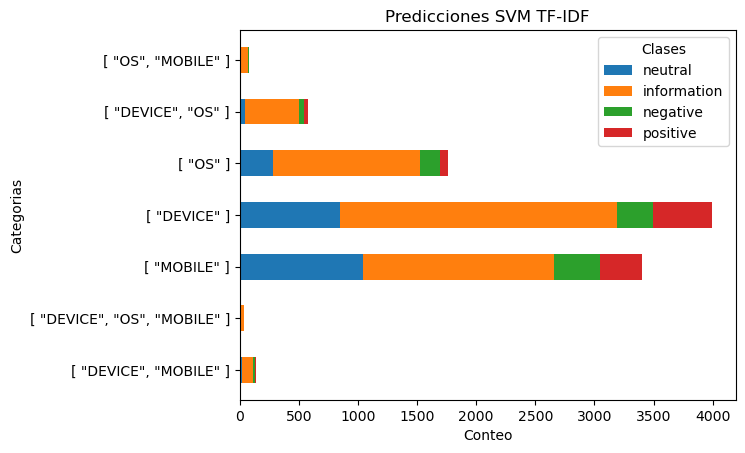

In [63]:
display(HTML('<table border="1" class="dataframe">\n <caption>Clases predecidas por categoría usando SVM TF-IDF </caption> <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>information</th>\n      <th>negative</th>\n      <th>neutral</th>\n      <th>positive</th>\n    </tr>\n    <tr>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th> "DEVICE" </th>\n      <td>2590.0</td>\n      <td>228.0</td>\n      <td>751.0</td>\n      <td>425.0</td>\n    </tr>\n    <tr>\n      <th> "DEVICE", "MOBILE" </th>\n      <td>93.0</td>\n      <td>9.0</td>\n      <td>25.0</td>\n      <td>15.0</td>\n    </tr>\n    <tr>\n      <th> "DEVICE", "OS" </th>\n      <td>461.0</td>\n      <td>39.0</td>\n      <td>42.0</td>\n      <td>37.0</td>\n    </tr>\n    <tr>\n      <th> "DEVICE", "OS", "MOBILE" </th>\n      <td>31.0</td>\n      <td>0.0</td>\n      <td>1.0</td>\n      <td>2.0</td>\n    </tr>\n    <tr>\n      <th> "MOBILE" </th>\n      <td>1795.0</td>\n      <td>296.0</td>\n      <td>1047.0</td>\n      <td>266.0</td>\n    </tr>\n    <tr>\n      <th> "OS" </th>\n      <td>1324.0</td>\n      <td>140.0</td>\n      <td>263.0</td>\n      <td>38.0</td>\n    </tr>\n    <tr>\n      <th> "OS", "MOBILE" </th>\n      <td>66.0</td>\n      <td>9.0</td>\n      <td>5.0</td>\n      <td>2.0</td>\n    </tr>\n  </tbody>\n</table>'))

,information,negative,neutral,positive
,,,,
"""DEVICE""",2590.0,228.0,751.0,425.0
"""DEVICE"", ""MOBILE""",93.0,9.0,25.0,15.0
"""DEVICE"", ""OS""",461.0,39.0,42.0,37.0
"""DEVICE"", ""OS"", ""MOBILE""",31.0,0.0,1.0,2.0
"""MOBILE""",1795.0,296.0,1047.0,266.0
"""OS""",1324.0,140.0,263.0,38.0
"""OS"", ""MOBILE""",66.0,9.0,5.0,2.0


Con base en los resultados anteriores, podemos decir que los algoritmos de clasificación que logran mejores resultados para esta tarea son los SVM ya sea que utilicen TF o TF-IDF. Esto se debe a que tienen un mejor desempeño en cuanto a micro $F_{1}$, lo que nos permite obtener predicciones más balanceadas y robustas para todas las clases, a diferencia de los clasificadores Naive Bayes que la mayor parte de las instancias las asignan a la clase mayoritaria, es decir information.

Por otra parte, debemos tomar en cuenta que aún pueden aplicarse técnicas para mejorar el desempeño de los algoritmos, como refinar el preprocesamiento del texto, optimización de los hiperparámetros de los algoritmos o técnicas para lidiar con el desbalance de clases.

# Conclusiones

La clasificación es una tarea fundamental en el procesamiento de lenguaje natural y el aprendizaje automático; sus aplicaciones y potencial son inmensas ya que permite el desarrollo de modelos predictivos, facilita el reconocimiento de patrones en texto y sirve como bloque de construcción para sistemas que ayuden a la toma de decisiones y proporcionen herramientas para recuperar, organizar y obtener conocimiento a partir de la vasta información textual que existe.

Finalmente, debe mencionarse que continuará siendo un área importante de cara al futuro, pues al seguir aumentando la información, será necesario contar con sistemas automáticos que permitan sacar el mayor provecho de ésta.